# 1. Environment Setup and Library Imports

This initial cell handles all the necessary imports for the project and verifies the hardware environment.

- **General Purpose**: `numpy` and `pandas` for data manipulation, `matplotlib` and `seaborn` for plotting.
- **Scikit-learn**: For splitting data (`train_test_split`) and evaluating models (`accuracy_score`, `classification_report`, `confusion_matrix`).
- **TensorFlow/Keras**: Used for building the LSTM model. This includes the `Tokenizer` for text processing, `pad_sequences` for standardizing input length, and layers like `Embedding`, `LSTM`, and `Dense`.
- **PyTorch/Hugging Face Transformers**: Used for the DistilBERT model. `torch` is the core library, and `AutoTokenizer` and `AutoModel` allow us to easily load pre-trained models from the Hugging Face hub.
- **Reproducibility**: `np.random.seed(42)` and `tf.random.set_seed(42)` are set to ensure that anyone running this code gets the exact same results.
- **GPU Verification**: The final part of the cell checks if TensorFlow and PyTorch can detect and use a GPU, which can dramatically speed up model training.

In [47]:
# --- General Purpose Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# --- TensorFlow and Keras Imports (for LSTM) ---
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# --- PyTorch and Transformers Imports (for BERT) ---
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LogisticRegression

# --- Set random seeds for reproducibility ---
np.random.seed(42)
tf.random.set_seed(42)

# --- GPU VERIFICATION ---
print("--- TensorFlow GPU Check ---")
print(f"Is GPU Available for TensorFlow: {len(tf.config.list_physical_devices('GPU')) > 0}")

print("\n--- PyTorch GPU Check ---")
print(f"Is GPU Available for PyTorch: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"PyTorch GPU Device: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

--- TensorFlow GPU Check ---
Is GPU Available for TensorFlow: False

--- PyTorch GPU Check ---
Is GPU Available for PyTorch: True
PyTorch GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU


# 2. Data Loading and Preprocessing

This section loads the dataset from a CSV file and prepares it for the models. Proper preprocessing is crucial for model performance.

**Key Steps:**
1.  **Load Data**: Reads `merged_sentiments.csv` into a pandas DataFrame.
2.  **Clean Column Names**: `df.columns.str.strip()` removes any accidental leading or trailing whitespace from the column names (e.g., changing `" sentiment "` to `"sentiment"`).
3.  **Clean Text Data**:
    - A new column `statement_clean` is created.
    - The text in the `statement` column is first converted to a string type using `.astype(str)` to prevent errors with non-text data (like empty cells).
    - It's then converted to lowercase using `.str.lower()` to ensure words like "Good" and "good" are treated as the same.
4.  **Map Labels to Integers**: Machine learning models work with numbers, not text labels. A `label_map` is created to convert `{'negative': 0, 'neutral': 1, 'positive': 2}`.
5.  **Handle Missing Labels**: The code checks for and drops any rows where the sentiment label could not be mapped, ensuring data integrity.
6.  **Split Data**: The dataset is split into training (80%) and testing (20%) sets using `train_test_split`.
    - `random_state=42` ensures the split is the same every time.
    - `stratify=y` is very important: it ensures that the proportion of positive, neutral, and negative samples is the same in both the training and testing sets, which prevents the model from being evaluated on an unrepresentative test set.

In [64]:
# Load the dataset
df = pd.read_csv('merged_sentiments.csv')

# --- FIX 1: Automatically clean up column names by removing leading/trailing spaces ---
df.columns = df.columns.str.strip()

# --- Now the rest of the code will work perfectly ---
print("Cleaned column names:", df.columns.tolist())

# Define the column names we will use
TEXT_COLUMN_NAME = 'statement'
SENTIMENT_COLUMN_NAME = 'sentiment'

# --- Data Cleaning and Mapping Labels ---
print("Original Dataset Shape:", df.shape)

# --- FIX 2: Convert the text column to string type BEFORE making it lowercase ---
# This handles empty cells (NaNs) or accidental numbers in the data safely.
df['statement_clean'] = df[TEXT_COLUMN_NAME].astype(str).str.lower()


# Create a mapping from string labels to integer labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
# Use the correct column name here
df['label'] = df[SENTIMENT_COLUMN_NAME].map(label_map)

# Check for any rows that didn't map correctly
print(f"\nRows with unmapped labels: {df['label'].isnull().sum()}")
df.dropna(subset=['label'], inplace=True) # Drop rows if any label is invalid
df['label'] = df['label'].astype(int)

print("\nFirst 5 Rows with Mapped Labels:")
print(df.head())

# Check new sentiment distribution
print("\nLabel Distribution:")
print(df['label'].value_counts())

# --- Prepare data for models ---
X = df['statement_clean'].values
y = df['label'].values

# Split data into training and testing sets, ensuring class distribution is maintained
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

Cleaned column names: ['statement', 'sentiment']
Original Dataset Shape: (781, 2)

Rows with unmapped labels: 0

First 5 Rows with Mapped Labels:
                                           statement sentiment  \
0  They have a clear and effective go-to-market s...  positive   
1  The recent acquisitions have only added more d...  negative   
2  They have a weak distribution network compared...  negative   
3  The management's unwavering focus on innovatio...  positive   
4  The company's assets are mostly intangible goo...  negative   

                                     statement_clean  label  
0  they have a clear and effective go-to-market s...      2  
1  the recent acquisitions have only added more d...      0  
2  they have a weak distribution network compared...      0  
3  the management's unwavering focus on innovatio...      2  
4  the company's assets are mostly intangible goo...      0  

Label Distribution:
label
0    283
2    280
1    218
Name: count, dtype: int64

Trai

# 3. Model 1: Bidirectional Long Short-Term Memory (LSTM)

This section builds, trains, and evaluates a Bidirectional LSTM model for multi-class sentiment analysis.

**Pipeline Steps:**
1.  **Tokenization and Padding**:
    - **Tokenizer**: A `Tokenizer` is created to convert words into integer IDs. `num_words=10000` limits the vocabulary to the 10,000 most common words. `oov_token="<OOV>"` assigns a special token for words not in the vocabulary.
    - **Padding**: Sentences have different lengths, but neural networks require fixed-size inputs. `pad_sequences` is used to make every sequence `120` tokens long by adding zeros (`padding='post'`) or cutting off words (`truncating='post'`).
2.  **Build the LSTM Model**:
    - `Sequential`: A linear stack of layers.
    - `Embedding`: This layer learns a dense vector representation (an "embedding") for each word in the vocabulary. Here, each word is mapped to a 32-dimensional vector.
    - `Bidirectional(LSTM(64))`: This is the core of the model. An LSTM is a type of recurrent neural network (RNN) excellent at learning from sequences. Wrapping it in `Bidirectional` allows the network to process the sequence both forwards and backwards, which often improves context understanding.
    - `Dense`: Standard fully-connected neural network layers.
    - `Dense(3, activation='softmax')`: The final output layer. It has **3 units** (one for each class: negative, neutral, positive) and uses the **softmax** activation function, which outputs a probability distribution across the classes.
3.  **Compile the Model**:
    - `loss='sparse_categorical_crossentropy'`: This is the correct loss function for multi-class classification when the true labels are integers (like 0, 1, 2).
    - `optimizer='adam'`: A standard, effective optimization algorithm.
4.  **Train and Evaluate**:
    - The model is trained for 30 `epochs` (passes over the training data).
    - `validation_data` is used to monitor performance on the test set after each epoch.
    - The final predictions are obtained using `np.argmax`, which selects the class with the highest probability from the softmax output.
    - The results are displayed with an accuracy score, a detailed classification report, and a visual confusion matrix.


--- Building the Multi-Class LSTM Model ---
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 120, 32)           320000    
                                                                 
 bidirectional_10 (Bidirect  (None, 128)               49664     
 ional)                                                          
                                                                 
 dense_20 (Dense)            (None, 32)                4128      
                                                                 
 dense_21 (Dense)            (None, 3)                 99        
                                                                 
Total params: 373891 (1.43 MB)
Trainable params: 373891 (1.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

--- Training the LSTM Model ---
Epoch

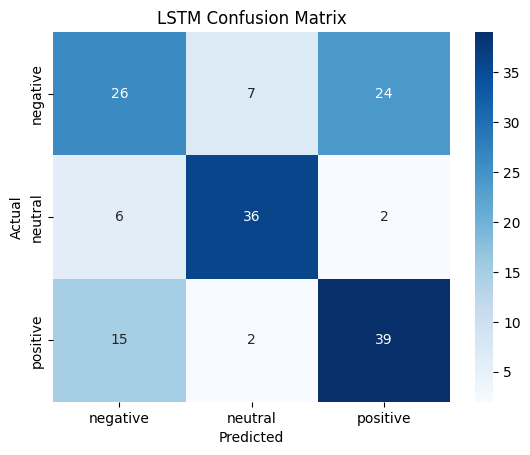

In [65]:
# --- Step 1: Tokenization and Padding ---
vocab_size = 10000
max_length = 120
embedding_dim = 32

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# --- Step 2: Build the LSTM Model for Multi-Class Classification ---
print("\n--- Building the Multi-Class LSTM Model ---")
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    # *** CHANGE HERE: 3 units for 3 classes, and 'softmax' for multi-class probability ***
    Dense(3, activation='softmax')
])

# *** CHANGE HERE: 'sparse_categorical_crossentropy' is used for multi-class integer labels ***
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

# --- Step 3: Train the LSTM Model ---
print("\n--- Training the LSTM Model ---")
history_lstm = model_lstm.fit(X_train_pad, y_train, epochs=30, validation_data=(X_test_pad, y_test), batch_size=32, verbose=2)

# --- Step 4: Evaluate the LSTM Model ---
print("\n--- Evaluating the LSTM Model ---")
y_pred_lstm_prob = model_lstm.predict(X_test_pad)
# *** CHANGE HERE: Use argmax to find the class with the highest probability ***
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)

print("LSTM Test Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("\nLSTM Classification Report:\n", classification_report(y_test, y_pred_lstm, target_names=label_map.keys()))

# Plotting the confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Training Process:
The training logs show the model's accuracy on the training data (accuracy) quickly rises to 1.0000 (100%).
However, the accuracy on the validation data (val_accuracy) peaks around 0.67 and then stagnates around 0.64.
This divergence is a classic sign of overfitting: the model has memorized the training data perfectly but fails to generalize to new, unseen data.
# Evaluation Results:
The final Test Accuracy is 64.3%, which is modest.
Classification Report:
The model is best at identifying neutral statements (F1-score of 0.81).
It struggles most with negative statements (F1-score of 0.50), showing low precision and recall for this class.
Confusion Matrix (Image): The matrix visually confirms the report. The diagonal (correct predictions) is brightest for the neutral class. There is significant confusion between negative and positive classes.

# 4. Model 2: Transformer (DistilBERT) + Logistic Regression

This section uses a much more powerful, pre-trained Transformer model called **DistilBERT**. Instead of training a deep network from scratch, we use DistilBERT to generate high-quality numerical representations (embeddings) of the text, and then train a simple classifier on these embeddings.

**Why this approach?**
- Transformer models like BERT are pre-trained on vast amounts of text data, giving them a deep understanding of language, grammar, and context.
- This technique, called **transfer learning**, allows us to achieve state-of-the-art results with much less data and training time than building from scratch.

**Pipeline Steps:**
1.  **Load Pre-trained Model**: `AutoTokenizer` and `AutoModel` from Hugging Face are used to download and load `distilbert-base-uncased`, a smaller, faster version of BERT. `.to(device)` moves the model to the GPU for acceleration.
2.  **Generate Embeddings**:
    - The `get_bert_embeddings` function takes a list of sentences.
    - It tokenizes them using the BERT tokenizer and feeds them into the model.
    - For each sentence, we extract the embedding of the special `[CLS]` token (the first token in the sequence), which is designed to be a summary representation of the entire sentence.
    - These embeddings (768-dimensional vectors) are generated for both the training and testing sets.
3.  **Train a Classifier**:
    - A simple `LogisticRegression` model from scikit-learn is trained on the generated embeddings. This classifier learns to map the 768-dimensional embedding vectors to the sentiment labels (0, 1, 2).
4.  **Evaluate**: The trained classifier is evaluated on the test set embeddings, and its performance is reported.

C:\Users\ashut\OneDrive\Documents\NLP\.venv\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Generating embeddings for 624 sentences...
Generating embeddings for 157 sentences...
Shape of training embeddings: (624, 768)
Shape of testing embeddings: (157, 768)

--- Training a Logistic Regression Classifier on BERT Embeddings ---

--- Evaluating the Transformer-based Classifier ---
Transformer + LR Test Accuracy: 0.9044585987261147

Transformer + LR Classification Report:
               precision    recall  f1-score   support

    negative       0.93      0.88      0.90        57
     neutral       0.91      0.98      0.95        44
    positive       0.88      0.88      0.88        56

    accuracy                           0.90       157
   macro avg       0.91      0.91      0.91       157
weighted avg       0.90      0.90      0.90       157



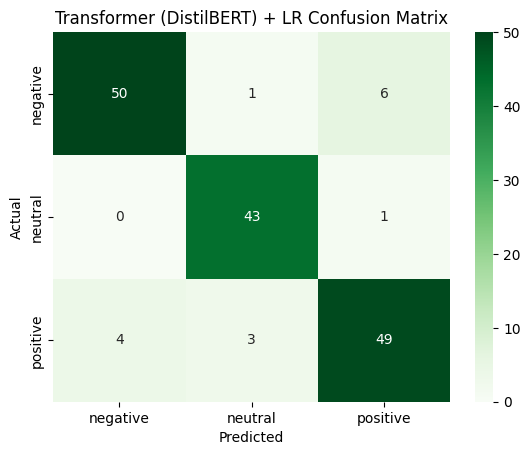

In [66]:
# --- Step 1: Load Pre-trained Transformer Model ---
# (No changes needed from the binary version)
model_name = 'distilbert-base-uncased'
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)
model_bert = AutoModel.from_pretrained(model_name).to(device)

# --- Step 2: Create a Function to Generate Embeddings ---
# (No changes needed)
def get_bert_embeddings(texts):
    print(f"Generating embeddings for {len(texts)} sentences...")
    inputs = tokenizer_bert(texts, return_tensors='pt', truncation=True, padding=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model_bert(**inputs)
    cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return cls_embeddings

# --- Step 3: Generate Embeddings for our Data ---
X_train_embeddings = get_bert_embeddings(list(X_train))
X_test_embeddings = get_bert_embeddings(list(X_test))

print("Shape of training embeddings:", X_train_embeddings.shape)
print("Shape of testing embeddings:", X_test_embeddings.shape)

# --- Step 4: Train a Classifier on the Embeddings ---
# (No changes needed - LogisticRegression handles multi-class automatically)
print("\n--- Training a Logistic Regression Classifier on BERT Embeddings ---")
classifier_lr = LogisticRegression(random_state=42, max_iter=1000)
classifier_lr.fit(X_train_embeddings, y_train)

# --- Step 5: Evaluate the Classifier ---
print("\n--- Evaluating the Transformer-based Classifier ---")
y_pred_bert = classifier_lr.predict(X_test_embeddings)

print("Transformer + LR Test Accuracy:", accuracy_score(y_test, y_pred_bert))
print("\nTransformer + LR Classification Report:\n", classification_report(y_test, y_pred_bert, target_names=label_map.keys()))

# Plotting the confusion matrix
cm_bert = confusion_matrix(y_test, y_pred_bert)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Greens', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Transformer (DistilBERT) + LR Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Embedding Shapes:
The output confirms that each of the 624 training sentences and 157 test sentences has been converted into a 768-dimensional vector.
# Evaluation Results:
    # The final Test Accuracy is 90.4%, a dramatic improvement over the LSTM's 64.3%.
    #Classification Report: All metrics (precision, recall, f1-score) are excellent across all three classes, with F1-scores around 0.90. This shows the model is highly effective and balanced.
    #Confusion Matrix (Image): The bright diagonal and very few off-diagonal numbers show that the model makes very few mistakes. This is a clear visual confirmation of its high performance.

# 5. Model Comparison and Conclusion

This cell provides a direct, side-by-side comparison of the two models' performances. The results clearly show the advantage of using a large, pre-trained Transformer model.

In [67]:
# --- Section 4: Comparison and Conclusion ---
import joblib
from tensorflow.keras.models import load_model
import json

# --- Print a summary of the results for comparison ---
lstm_accuracy = accuracy_score(y_test, y_pred_lstm)
bert_accuracy = accuracy_score(y_test, y_pred_bert)

results_summary = pd.DataFrame({
    'Model': ['LSTM (from Scratch)', 'Transformer (DistilBERT) + Logistic Regression'],
    'Test Accuracy': [lstm_accuracy, bert_accuracy]
})

print("--- FINAL RESULTS COMPARISON ---")
print(results_summary)

print("\n### Analysis ###")
print("The Transformer-based model is clearly superior in performance and will be saved for future use.")

--- FINAL RESULTS COMPARISON ---
                                            Model  Test Accuracy
0                             LSTM (from Scratch)       0.643312
1  Transformer (DistilBERT) + Logistic Regression       0.904459

### Analysis ###
The Transformer-based model is clearly superior in performance and will be saved for future use.


- **The summary table quantifies the performance difference: 90.4% accuracy for the Transformer model vs. 64.3% for the LSTM.**
- **The analysis correctly concludes that the Transformer-based approach is the winning strategy and should be saved for the final application.**


# 6. Saving the Model for Future Use

To use our model in an application without retraining it every time, we need to save its essential components.

- **Logistic Regression Classifier**: The trained `classifier_lr` object is saved using `joblib.dump`. This is the standard way to save scikit-learn models.
- **Keras Tokenizer**: The tokenizer from the LSTM part is saved as a JSON file. While not used in the winning pipeline, it's good practice to save it if you might need it later.
- **LSTM Model**: The entire LSTM model is saved in the Keras format. This is marked as optional since it was the weaker model.

**Note**: We don't save the DistilBERT model itself. It can be easily and quickly re-downloaded from the Hugging Face Hub just by using its name (`'distilbert-base-uncased'`), which is more efficient.

In [68]:
# --- Section 5: Saving the Models for Future Use ---

# The Transformer-based model is the clear winner, so we will save its components.

# 1. Save the trained Logistic Regression classifier
model_filename = 'lr_classifier.joblib'
joblib.dump(classifier_lr, model_filename)
print(f"Logistic Regression classifier saved to: {model_filename}")

# 2. Save the Keras Tokenizer (from the LSTM part, just in case you want to reuse it)
tokenizer_json = tokenizer.to_json()
with open('keras_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))
print(f"Keras tokenizer saved to: keras_tokenizer.json")

# 3. Save the full LSTM model (optional, as it's the weaker model)
model_lstm.save('lstm_model.keras')
print(f"Full LSTM model saved to: lstm_model.keras")

# NOTE: We don't need to save the DistilBERT model itself,
# because we can always reload it from the Hugging Face library using its name ('distilbert-base-uncased').

Logistic Regression classifier saved to: lr_classifier.joblib
Keras tokenizer saved to: keras_tokenizer.json
Full LSTM model saved to: lstm_model.keras


In [71]:
# --- Section 6: Loading and Using the Saved Models for Inference ---

print("\n--- INFERENCE PIPELINE DEMONSTRATION ---")

# 1. Define the components needed for the winning pipeline
TRANSFORMER_MODEL_NAME = 'distilbert-base-uncased'
CLASSIFIER_PATH = 'lr_classifier.joblib'
# The label map from our training script
INVERSE_LABEL_MAP = {0: 'negative', 1: 'neutral', 2: 'positive'}

# 2. Load the saved components
# Load the classifier
loaded_classifier = joblib.load(CLASSIFIER_PATH)
# Load the Transformer tokenizer and model (this is fast)
inference_tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL_NAME)
inference_model = AutoModel.from_pretrained(TRANSFORMER_MODEL_NAME).to(device)

print("Inference components loaded successfully.")

# 3. Create a prediction function
def predict_sentiment(text):
    """
    Takes a raw text string and predicts its sentiment using the saved model.
    """
    # Move model to evaluation mode
    inference_model.eval()

    # Preprocess the text: lowercase and create embedding
    text_lower = text.lower()

    # Tokenize and create tensor, move to GPU
    inputs = inference_tokenizer(text_lower, return_tensors="pt", truncation=True, padding=True).to(device)

    # Get embeddings from the Transformer model
    with torch.no_grad():
        outputs = inference_model(**inputs)

    cls_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()

    # Use the loaded classifier to predict
    prediction_id = loaded_classifier.predict(cls_embedding)[0]
    prediction_proba = loaded_classifier.predict_proba(cls_embedding)[0]

    # Map prediction ID back to label and get confidence
    sentiment_label = INVERSE_LABEL_MAP[prediction_id]
    confidence = prediction_proba[prediction_id]

    return sentiment_label, confidence

# 4. Test the pipeline with new sentences
new_statements = [
    "This company has a great growth trajectory, the IPO is a definite buy.",
    "I am concerned about the company's high debt and thin profit margins.",
    "The IPO prospectus indicates the offering will be available on Monday.",
    "Market sentiment is bearish, this is a risky bet.",
    "I had to rub my eyes thrice when I saw the Lenskart IPO valuation. 70,000 crores is simply too high.",
    "Canara Bank has reduced its stake in Canara HSBC Life Insurance Company Limited from 51% to 36.50% through an Initial Public Offer (IPO).",
    "Lenskart GMP crashes to zero, wiping out all pre-listing buzz ahead of Monday debut",
    "The grey market premium (GMP) for eyewear retailer Lenskart Solutions has crashed to zero, wiping out all pre-listing excitement ahead of its market debut on Monday. The GMP, which had peaked at Rs 108, implying a listing pop of over 25% before the announcement of the IPO, has now collapsed, signalling that the counter may see a flat or muted listing despite its healthy subscription.",
    "Lenskart IPO allotment on November 06: Check status online on NSE, BSE; GMP slumps 66% from peak ahead of allotment",
    "The Lenskart Solutions IPO was opened on October 31 and closed on November 4. The price band is Rs 382-402 per share.The company plans to raise Rs 7,278 crore from the market. This includes a fresh issue worth Rs 2,150 crore and an offer for sale of Rs 5,128 crore. The IPO allotment is expected to be finalised on November 6, and shares are likely to list on November 10 on the BSE and NSE.",
    "The grey market premium (GMP) for eyewear retailer Lenskart Solutions has crashed to zero, wiping out all pre-listing excitement ahead of its market debut on Monday. The GMP, which had peaked at Rs 108, implying a listing pop of over 25% before the announcement of the IPO, has now collapsed, signalling that the counter may see a flat or muted listing despite its healthy subscription.",
    "Hyundai Motor IPO: GMP for India's largest-ever issue plunges 70% amid high valuation, Ahead of the opening of the highly-anticipated initial public offering (IPO) of Hyundai Motor India next week, the grey market premium (GMP) of its shares crashed by over 70% in the unlisted market. The GMP of Hyundai Motor shares have dropped from its peak of ₹570 on September 27 to ₹165 on October 10, indicating the listing price to be around ₹2,125, a premium of 8.4% over the issue price. The GMP has witnessed sharp correction in three sessions, from ₹270 on October 7 to ₹147 on October 8, after the auto major announced the price band for its upcoming IPO at ₹1,865-1,960 per share. The drop in the GMP of Hyundai Motor shares can be attributed to its “rich valuations” coupled with volatility in the domestic equity market amid escalated geo-political tensions.Hyundai Motor India is seeking a slightly higher premium to Maruti and lower to M&M based on price earnings ratio while the company stands to be expensive in terms of price to book value. Hyundai India justifies its premium ask considering its leadership in SUV sales, world class brand image followed by better safety ratings, multi segment growth visibility largely been driven by its popular SUVs, particularly the Creta, Exter, and Venue models in the Indian market,” says Tapse.On valuation perse based on annualised FY25e expectation the issue appears fully priced-in leaving no room for any healthy listing gain,” he adds.Despite contributing only 6.5% of Hyundai's global revenues and 8% of its profitability, Hyundai’s India is asking for premium valuation even when compared to its South Korean parent entity, Hyundai Motor Group, which is trading at 5-6-time price-to-earnings (PE) ratio and valued 42% of the South Korean parent's market capitalisation on listing.Despite global headwinds and domestic inventory pressure, the country’s largest-ever IPO is eagerly awaited by investors and is expected to garner good response when it opens for subscription on October 15.Domestic brokerage Anand Rathi has recommended “Subscribe – Long Term” rating to the IPO, saying that HMIL has consistently held the position as the leading auto OEM in India by sales volume in the mid-size SUV sub-segment from Fiscal Year 2019 through the three months ending on June 30, 2024"

]

for stmt in new_statements:
    sentiment, confidence = predict_sentiment(stmt)
    print(f"\nStatement: '{stmt}'")
    print(f"--> Predicted Sentiment: {sentiment.upper()} (Confidence: {confidence:.2f})")


--- INFERENCE PIPELINE DEMONSTRATION ---


C:\Users\ashut\OneDrive\Documents\NLP\.venv\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Inference components loaded successfully.

Statement: 'This company has a great growth trajectory, the IPO is a definite buy.'
--> Predicted Sentiment: POSITIVE (Confidence: 0.99)

Statement: 'I am concerned about the company's high debt and thin profit margins.'
--> Predicted Sentiment: NEGATIVE (Confidence: 0.99)

Statement: 'The IPO prospectus indicates the offering will be available on Monday.'
--> Predicted Sentiment: NEUTRAL (Confidence: 0.98)

Statement: 'Market sentiment is bearish, this is a risky bet.'
--> Predicted Sentiment: NEGATIVE (Confidence: 0.96)

Statement: 'I had to rub my eyes thrice when I saw the Lenskart IPO valuation. 70,000 crores is simply too high.'
--> Predicted Sentiment: NEGATIVE (Confidence: 0.91)

Statement: 'Canara Bank has reduced its stake in Canara HSBC Life Insurance Company Limited from 51% to 36.50% through an Initial Public Offer (IPO).'
--> Predicted Sentiment: NEUTRAL (Confidence: 0.98)

Statement: 'Lenskart GMP crashes to zero, wiping out all